# Concepts in engineering data for quantitative finance and econometrics.

The FRED database and API is a great one to learn. It is the largest freely available point-in-time database I am aware of (if you hear of others please let me know!). The source code in this fredapi library provides an example of a few fundamental tasks.

- Wrangling public data with the requests package
- Transforming point-in-time dataset into time series panels with pandas
- Structuring reusable code for deployment as a python package

Modeling with financial and economic data is almost always (i) reported with lags and (ii) subject to revisions.

This notebook illustrates how to use the source code to further transform economic data into model features that are robust to look ahead bias.

In [114]:
# import the library
from fredapi import FredAPI

The API requires an API Key. You can get one for free by creating an account at https://fred.stlouisfed.org/docs/api/api_key.html

I've saved my key in a file called secrets and reading it in here for the purpose of the notebook. You don't have to save it as a file, I just did that because I plan on putting this notebook on the internet. You could also just instantiate an API object with your key by doing: 

>api = FredAPI('enter your key here')

In [115]:
with open('secrets', 'r') as f:
    my_api_key = f.read().strip()

api = FredAPI(my_api_key)

I included just two of the fred endpoints in the source code. 

- search_series: runs a search for items in the fred database. 
- get_panel: returns panel data for a particular item. 

There are more enpoints that could be wrapped. For example, they have an endpoint that returns information on categories, sources, and release dates for economic data prints. A full list of endpoints is documented here [https://fred.stlouisfed.org/docs/api/fred/](https://fred.stlouisfed.org/docs/api/fred/)

In [116]:
# The source code includes doc strings with some basic information about the functions
api.search_series?

Signature: api.search_series(search_text: str) -> pandas.core.frame.DataFrame
Docstring:
Search for series by keywords.

:param search_text: The text to search for.
:return: A dataframe containing the search results.

Example:
>>> api = FredAPI(api_key="your_api_key")
>>> df = api.search_series(search_text="GDP")
>>> df.head()
File:      ~/repos/fredapi/fredapi/__init__.py
Type:      method

In [117]:
# Searching for retail sales and displaying the first 5 results
df = api.search_series('retail sales')
df.head(5)

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,group_popularity,notes
0,TOTALSA,2025-02-28,2025-02-28,Total Vehicle Sales,1976-01-01,2025-01-01,Monthly,M,Millions of Units,Mil. of Units,Seasonally Adjusted Annual Rate,SAAR,2025-02-28 08:00:22-06,76,77,NaN
1,TOTALNSA,2025-02-28,2025-02-28,Total Vehicle Sales,1976-01-01,2025-01-01,Monthly,M,Thousands of Units,Thous. of Units,Not Seasonally Adjusted,NSA,2025-02-28 08:00:21-06,49,77,NaN
2,RSXFS,2025-02-28,2025-02-28,Advance Retail Sales: Retail Trade,1992-01-01,2025-01-01,Monthly,M,Millions of Dollars,Mil. of $,Seasonally Adjusted,SA,2025-02-14 07:34:20-06,71,72,E-commerce sales are included in the total mon...
3,RSXFSN,2025-02-28,2025-02-28,Advance Retail Sales: Retail Trade,1992-01-01,2025-01-01,Monthly,M,Millions of Dollars,Mil. of $,Not Seasonally Adjusted,NSA,2025-02-14 07:34:21-06,40,72,E-commerce sales are included in the total mon...
4,MARTSMPCSM44000USS,2025-02-28,2025-02-28,Advance Retail Sales: Retail Trade,1992-02-01,2025-01-01,Monthly,M,Percent Change from Preceding Period,% Chg. from Preceding Period,Seasonally Adjusted,SA,2025-02-14 07:34:02-06,29,72,The value for the most recent month is an adva...


Let's say I am interested in calculating the 3-month over 3-month seasonally adjusted annualized growth rate (3m3mSAAR) of the advanced retail sales indicator. This is a smoothing transformation and can be useful for identifying inflection points in the trend of many economic time series.

Retail sales is a flow number and 3m3mSAAR is the annualized growth rate of the sum of the three most recently reported seasonally adjusted monthly sales over the sum of preceeding three months.

The third item in the search result tells me that RSXFS is the item mneumonic for the monthly seasonally adjusted retail sales release.

The get_panel function takes this item mneumonic as an input to get the data. 

In [118]:
api.get_panel?

Signature:
api.get_panel(
    series_id: str,
    observation_dates: Iterable,
    window: int = 24,
) -> pandas.core.frame.DataFrame
Docstring:
Get a panel of data for a given series ID.

:param series_id: The series ID to retrieve.
:param observation_dates: A list of dates to retrieve data for.
:param window: The number of periods back to retrieve for each observation date.

:return: A dataframe containing the panel data.

Example:
>>> api = FredAPI(api_key="your_api_key")
>>> observation_dates = pd.date_range(start="2020-01-01", end="2025-01-01", freq='M')
>>> df = api.get_panel(series_id="RSXFSN", observation_dates=observation_dates)
>>> df.head()
File:      ~/repos/fredapi/fredapi/__init__.py
Type:      method

There is not an industry standard vocabulary for all the concepts when dealing with point-in-time data. In this function, "Observation Dates", "Window", and "Periods Back" can be interpreted as follows: 

- Observation Date: if I have a time machine and travel back to this date to query a time series of seasonally adjusted retail sales, what data would I get back from that query?
  
- Window: how many "periods back" do I want to see at each observation date. This is optional and if left out the function will return the full history of data known at each observation date. However, since this is a monthly series and I am calculating 3m3mSAAR, I only need 6 periods back. 

- Period Back: financial and economic data is almost always reported to the public with a lag. Furthermore, the data are often reported on a consistent frequency (e.g., daily, weekly, monthly, quarterly, annually). In practice we can abstract away this complexity by doing fundamental research about time series we are working with and normalizing the panels in terms of observation dates and periods back. For example, when working with retail sales, we know (i) it is a monthly time series, (ii) it is "flow" data (as opposed to "stock" data, like inventories), and (iii) the first estimate of the data for each month is released about two weeks following the end of each month. Like any time series, we'll model this in two dimensions like a key-value pair. But since we're dealing with panels, we are most interested in observation date, because we're interested in "what the market knew" at that particular date. All other dates are viewed though the lens of periods back, and it's on us to understand the series we're working with.


In [119]:
# Define a series of observation dates
#    (we're going to travel back in time to each of these dates and getting a view 
#     of what the market "knew" at that particular point in time)

import pandas as pd
observation_dates = pd.date_range(start="2010-01-01", end="2025-01-01", freq='ME') # ME = month end

observation_dates

DatetimeIndex(['2010-01-31', '2010-02-28', '2010-03-31', '2010-04-30',
               '2010-05-31', '2010-06-30', '2010-07-31', '2010-08-31',
               '2010-09-30', '2010-10-31',
               ...
               '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30',
               '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31',
               '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', length=180, freq='ME')

In [120]:
# Query the data, the get_panel returns a multi index dataframe. 
df = api.get_panel('RSXFS', observation_dates=observation_dates, window=6)

df

value       date
observation_date periods_back                     
2010-01-31       1               315041 2009-12-01
                 2               315789 2009-11-01
                 3               309821 2009-10-01
                 4               305865 2009-09-01
                 5               312879 2009-08-01
...                                 ...        ...
2024-12-31       2             622551.0 2024-10-01
                 3             620104.0 2024-09-01
                 4             614535.0 2024-08-01
                 5             615960.0 2024-07-01
                 6             607986.0 2024-06-01

[1080 rows x 2 columns]

For example, if you travel back in time to January 31, 2010, the most recently available seasonally adjusted retail sales print was 315,041 million December 2009. Note, the January 2010 retail sales number had not been published yet.

In [121]:
df.loc['2010-01-31']

,value,date
periods_back,,
1,315041,2009-12-01
2,315789,2009-11-01
3,309821,2009-10-01
4,305865,2009-09-01
5,312879,2009-08-01
6,304450,2009-07-01


Below is what it would look like if you travelled in time to February 28, 2010 and made the same query. Note how the sales for December and November have been revised, as the census gathered more data, refined their measure of retail sales in those months, and published their revisions.

For example, retail sales for December were released at 315,041 in January and revised to 316,117 in February. 

In [122]:
df.loc['2010-02-28']

,value,date
periods_back,,
1,317573,2010-01-01
2,316117,2009-12-01
3,316424,2009-11-01
4,309821,2009-10-01
5,305865,2009-09-01
6,312879,2009-08-01


As noted above, and depending on the data you are working with, it may be interesting to know the 'date' associated with a period back. However, we would like to know the data item well enough to abstract away into periods back. In this case we know that retail sales is a monthly series produced by the census and released mid-month for the month prior. The methodology documents on the census bureau website would also tell us their process for conducting the surveys and the revision process. Noteably, they publish two revision following the initial release, followed by an annual revision, etc. 

If we were cultivating this data for a production use case, those reference materials would be required reading. 

But for the purpose of this notebook, let's skip ahead and calculate a 3m3mSAAR using the panel dataset. 

In [123]:
# Transform the dataframe to perform rolling calculations by sorting by observation date and periods back
df = df['value'].reset_index() \
    .sort_values(['observation_date', 'periods_back'], ascending=[True, False]) \
    .reset_index(drop=True)

df

,observation_date,periods_back,value
0,2010-01-31,6,304450
1,2010-01-31,5,312879
2,2010-01-31,4,305865
3,2010-01-31,3,309821
4,2010-01-31,2,315789
...,...,...,...
1075,2024-12-31,5,615960.0
1076,2024-12-31,4,614535.0
1077,2024-12-31,3,620104.0
1078,2024-12-31,2,622551.0


In [124]:
# Add the 3 month rolling sum
df['3m_avg'] = df.groupby('observation_date')['value'].rolling(3).sum().reset_index(drop=True)

df


,observation_date,periods_back,value,3m_avg
0,2010-01-31,6,304450,NaN
1,2010-01-31,5,312879,NaN
2,2010-01-31,4,305865,923194.0
3,2010-01-31,3,309821,928565.0
4,2010-01-31,2,315789,931475.0
...,...,...,...,...
1075,2024-12-31,5,615960.0,NaN
1076,2024-12-31,4,614535.0,1838481.0
1077,2024-12-31,3,620104.0,1850599.0
1078,2024-12-31,2,622551.0,1857190.0


In [125]:
# Add the 3 month / 3 month growth rate
df['3m3m_chg'] = df.groupby('observation_date')['3m_avg'].pct_change(periods=3, fill_method=None).reset_index(drop=True)

df

,observation_date,periods_back,value,3m_avg,3m3m_chg
0,2010-01-31,6,304450,NaN,NaN
1,2010-01-31,5,312879,NaN,NaN
2,2010-01-31,4,305865,923194.0,NaN
3,2010-01-31,3,309821,928565.0,NaN
4,2010-01-31,2,315789,931475.0,NaN
...,...,...,...,...,...
1075,2024-12-31,5,615960.0,NaN,NaN
1076,2024-12-31,4,614535.0,1838481.0,NaN
1077,2024-12-31,3,620104.0,1850599.0,NaN
1078,2024-12-31,2,622551.0,1857190.0,NaN


In [126]:
# After performing the 3 period pct_change, period back 1 is the only record with a value
# There is no longer any useful information in the other periods back in the dataframe...
# ... recall this example used a 6 period back window knowing that is as much data as is needed for the 3m3m calc)
df = df.loc[df['periods_back'] == 1]

df.set_index('observation_date')['3m3m_chg']

observation_date
2010-01-31    0.018909
2010-02-28    0.023207
2010-03-31    0.018849
2010-04-30    0.017760
2010-05-31    0.023532
                ...   
2024-08-31    0.004511
2024-09-30    0.006331
2024-10-31    0.012787
2024-11-30    0.011767
2024-12-31    0.017454
Name: 3m3m_chg, Length: 180, dtype: float64

In [127]:
# The above cell is 3m3mSA.. annualize it to get 3m3mSAAR noting retail sales are monthly and not compounding.
rs_3m3msaar = df.set_index('observation_date')['3m3m_chg']*4

rs_3m3msaar

observation_date
2010-01-31    0.075637
2010-02-28    0.092827
2010-03-31    0.075395
2010-04-30    0.071038
2010-05-31    0.094126
                ...   
2024-08-31    0.018043
2024-09-30    0.025323
2024-10-31    0.051148
2024-11-30    0.047068
2024-12-31    0.069816
Name: 3m3m_chg, Length: 180, dtype: float64

<Axes: title={'center': 'Retail Sales 3m3mSAAR'}, xlabel='observation_date'>

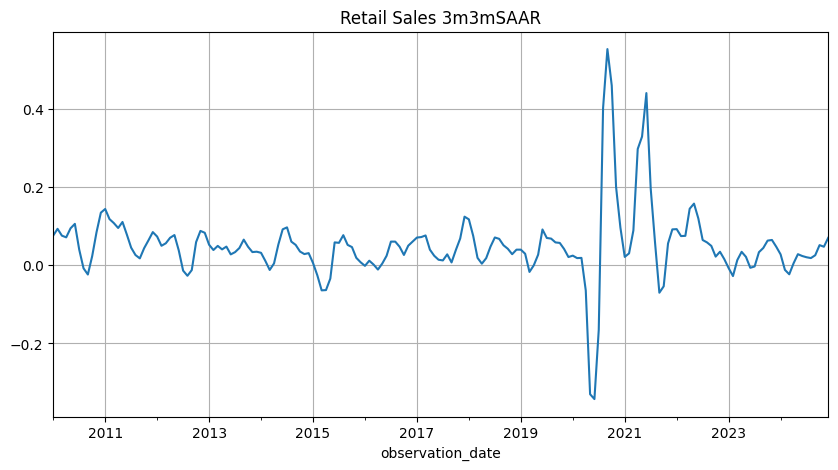

In [128]:
#!pip install -U matplotlib
rs_3m3msaar.plot(figsize=(10, 5), title='Retail Sales 3m3mSAAR', grid=True)

To recap:

- Financial and economic data is almost always (i) reported with lags and (ii) subject to revisions.
- This is an illustrative example of engineering a time series of retail sales growth that is robust to look ahead bias.